## Barclays Data Science Exercise

Fraud detection is a topic applicable to many sectors, including financial services and insurance.
In this exercise, you will be asked to build a predictive model for predicting fraud and a simple
application to simulate the model running on unseen data.
The target variable ‘isFraud’ should be used and the ‘isFlaggedFraud’ variable must be
ignored for the purpose of this analysis.

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
import pandas as pd
import numpy as np
import datetime, time
import itertools, pickle
import requests, json

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, roc_curve, auc
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Exploring the data

In [2]:
raw_data = pd.read_csv('/media/d/Python/dasaChallenge/PS_20174392719_1491204439457_log.csv')

In [3]:
raw_data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


### Casting the categorical variables

In [4]:
raw_data['isFraud'] = raw_data['isFraud'].astype('category')
raw_data['isFlaggedFraud'] = raw_data['isFlaggedFraud'].astype('category')

In [5]:
raw_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


### Checking the imbalance of the problem

In [6]:
imbalance = raw_data.isFraud.value_counts()
print(imbalance)
print('Class Imbalance = {}'.format(imbalance[1]/(imbalance[0]+imbalance[1])*100))

0    6354407
1       8213
Name: isFraud, dtype: int64
Class Imbalance = 0.12908204481801522


The Fraud rate is ~0.13%. ie, the dataset is extremely imbalanced. So rebalancing the dataset might be required. But the results obtained on a rebalanced dataset could be far off from the real-world performance of the model.

SInce this is an extremely imbalanced classification problem, Accuracy is not the metric that we should be optimizing for. A model which predicts all the transactions as Non-Fraud would achieve 99.87% accuracy.

### Checking for any missing values

In [7]:
raw_data.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

### Checking the volumes of different transaction types

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


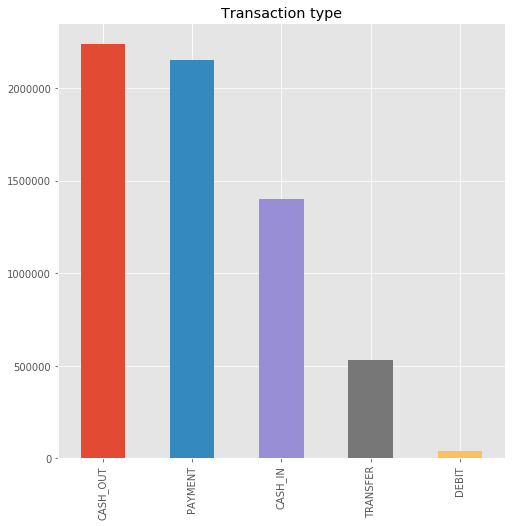

In [8]:
print(raw_data.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
raw_data.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

#### Checking the number of Frauds in each Transaction type

In [9]:
pd.crosstab(raw_data['type'], raw_data['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


Here we see that the fraud occurs only in CASH_OUT and TRANSFER transactions. This is inline with the description given for 'isFraud' variable. This means that we can make a model only using TRANSFER and CASH_OUT types while directly returning result as 'notFraud' for other types using an if condition check. This will make the model faster in production as the model needs to be executed only for 2 types.

## Feature Engineering

The description of 'isFraud' states that in this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. We need to investigate whether this is the case, then those accounts may be marked as suspicious accounts and can be made into feature for the model. During productionization, a suspicious account database may be maintained which returns 'True' if an account is present in it.

We are neglecting the 'isFlaggedFraud' variable as per the instructions given.

In [10]:
fraudTransfer = raw_data.loc[(raw_data.isFraud == 1) & (raw_data.type == 'TRANSFER')] #Subset all Trasfer Frauds
fraudCashout = raw_data.loc[(raw_data.isFraud == 1) & (raw_data.type == 'CASH_OUT')] #Subset all CashOut Frauds

print('Within fraudulent transactions, are there destinations for TRANSFERS \
 that are also originators for CASH_OUTs? {}'.format(\
 fraudTransfer.nameDest.isin(fraudCashout.nameOrig).any())) # False

Within fraudulent transactions, are there destinations for TRANSFERS  that are also originators for CASH_OUTs? False


This shows that there are no such common accounts among fraudulent transactions. So this feature cannot be engineered.

### Exploration in RStudio and Jupyter-R notebook ---> GoTo dataChallengeR.ipynb and dasaChallenge.R
Since we couldn't find any connection between the nameDest and nameOrig columns with the target variable 'isFraud', we can discard these columns for modelling purposes.

### Data Cleaning

In [11]:
X = raw_data.loc[(raw_data.type == 'TRANSFER') | (raw_data.type == 'CASH_OUT')].reset_index(drop=True) #Taking only TRANSFER and CASH_OUT for model building

randomState = 5
np.random.seed(randomState)

Y = X['isFraud'] #Taking the target variable to a new dataFrame
del X['isFraud']

# Drop the irrelevant columns
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [12]:
Xfraud = X.loc[Y == 1] #Taking all Frauds into a dataFrame
XnonFraud = X.loc[Y == 0] #Taking all nonFrauds into a dataFrame

print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & \
(Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldbalanceDest == 0) & \
(XnonFraud.newbalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


We see that the destination account balances being zero is a strong indicator of fraud.

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%).

Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we create 2 new features recording errors in the originating and destination accounts for each transaction.

In [14]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

#### Visualizing the features used for Model Building

In [15]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
0,1,0,181.00,181.0,0.0,0.0,0.00,0.00,181.0
1,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
2,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
3,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
4,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


In [16]:
print ("data_used shape:", X.shape)
print(X.info())

data_used shape: (2770409, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2770409 entries, 0 to 2770408
Data columns (total 9 columns):
step                int64
type                int64
amount              float64
oldbalanceOrg       float64
newbalanceOrig      float64
oldbalanceDest      float64
newbalanceDest      float64
errorBalanceOrig    float64
errorBalanceDest    float64
dtypes: float64(7), int64(2)
memory usage: 190.2 MB
None


### Plotting the correlation between the features

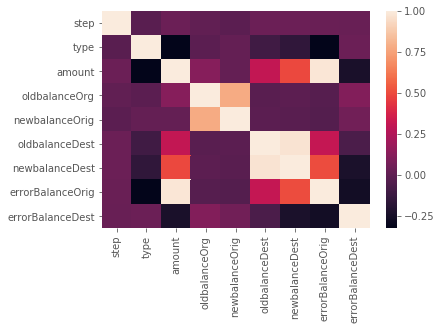

In [18]:
sns.heatmap(X.corr())

Here we see that the different variables are not very correlated to each other. So dropping of correlated variables are not required.

## Model Building

We are dealing with a highly imbalanced binary classification problem. So we have to select:
1. An appropriate Machine learning algorithm
2. How to deal with the class imbalance 
3. The selection of the metric for which we are optimizing.



The common machine learning algorithms for classification are:
1. Logistic Regression
2. Support Vector Machines
3. Decision Tree/Random Forest/XGBoost
4. Neural Networks/Deep Learning

Logistic Regression and Support Vector Machines search for a linear separating boundary between the +ve and -ve classes. There is an intuitive explanation that Logistic regression tries to get the -ve class scores as close to 0 as possible and the +ve class scores as close to 1 as possible. Whereas SVM is only concerned about the points that lie closer to the hyperplane and it tries to maximize the width of the separating hyper-plane. SVM's loss function is not affected by the points that are far from the hyperplane. SVMs and Logistic regression can be used for non-linear boundaries using the kernel trick.

Decision Tree, Random Forest and XGBoost are all Tree-based algorithms. They divide the feature space using horizontal and vertical hyper-planes. So if the actual class boundary is very non-linear, tree based methods would outperform a linear classifier and vice-versa. Decision trees have high variance, an ensemble of many trees will decrease variance.

A Randon Forest is an ensemble of Decision Trees in with each tree fitted on a bootstrapped dataset with replacement (bagging) and a clever way of decorrelating the individual trees. XGBoost is also an ensemble of Decision Trees in whith each tree fitted on a bootstrapped dataset with replacement but with boosting. i.e., the subsequent trees are fitted to the errors made by the previous trees. In XGBoost, since each tree learns from the errors made by the previous tree, it can classify hard to classify points effectively. It also have many features which make it ideal to use in a Barclays production environment.

Tree based methods can automatically take into account interactions between variables, e.g. xy if you have two independent features x and y. With logistic regression, we will have to manually add those interaction terms. Tress can also handle non-linear features. Because of these advantages, we are going with tree based approach (In our case XGBoost) here. 

Neural Networks/Deep Learning generally perform well in the presence of huge amounts of data while the algorithms above plateau out even when we increase the training data set. Since the data available in this problem is less, we are not considering this modelling technique for this problem. For smaller datasets, conventional classifiers generally outperform neural networks.

In [18]:
print('Class Imbalance Percentage = {}'.format((len(Xfraud) / float(len(X)))*100))

Class Imbalance Percentage = 0.2964544224336551


We have kept only CASH_OUT and TRANSFER transactions for training the model. This has improved the imbalance from the previous 0.13% to 0.3%. A small change but a positive one for modelling.

Selection of metric:  I am using the area under the precision-recall curve (AUPRC) rather than receiver operating characteristic (AUROC). An intuitive expalanation of the choice available at:
Link: http://www.chioka.in/differences-between-roc-auc-and-pr-auc/

Using 80% of data for train and 20% for testing.

In [19]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

Accounting for Class Imbalance: There are several methods for dealing with class imbalance. A very good explanation is available at:
Link: https://www.svds.com/learning-imbalanced-classes/

Here I am using the 'scale_pos_weight' hyper-parameter of the XGBoost algorithm to account for the class imbalance. This parameter can be used to inject the risk-appetite of the business (in this case Barclays) into the model.

In [21]:
# Model Training. Long Computation in this cell
weights = (Y == 0).sum() / ((Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)

probabilities = clf.fit(trainX, trainY).predict_proba(testX)
predictY = clf.predict(testX)

print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

AUPRC = 0.9985965385666989


#### Save the model using Pickle for use in Streaming service

In [22]:
xgbFile = open('XGBModel.pckl', 'wb')
pickle.dump(clf, xgbFile)
xgbFile.close()

#### Test saved Pickle Model Predictions

In [24]:
xgbFile = open('/media/d/Python/flaskServer/models/XGBModel.pckl', 'rb')
xgbModel = pickle.load(xgbFile)
xgbFile.close()

step=45435
transactionType=2
amount=181.00
oldbalanceOrg=181.0
newbalanceOrig=4343
oldbalanceDest=494309534
newbalanceDest=95439543
errorBalanceOrig = newbalanceOrig + amount - oldbalanceOrg
errorBalanceDest = oldbalanceDest + amount - newbalanceDest

columnNames=['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']
testData = np.array([step, transactionType, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, errorBalanceOrig, errorBalanceDest]).reshape(1,9)
pdTest = pd.DataFrame(testData, columns=columnNames)
class_prediced = int(xgbModel.predict(pdTest))
output = "Predicted Class: " + str(class_prediced)
print(output)

Predicted Class: 0


#### Feature Importance of XGBoost model

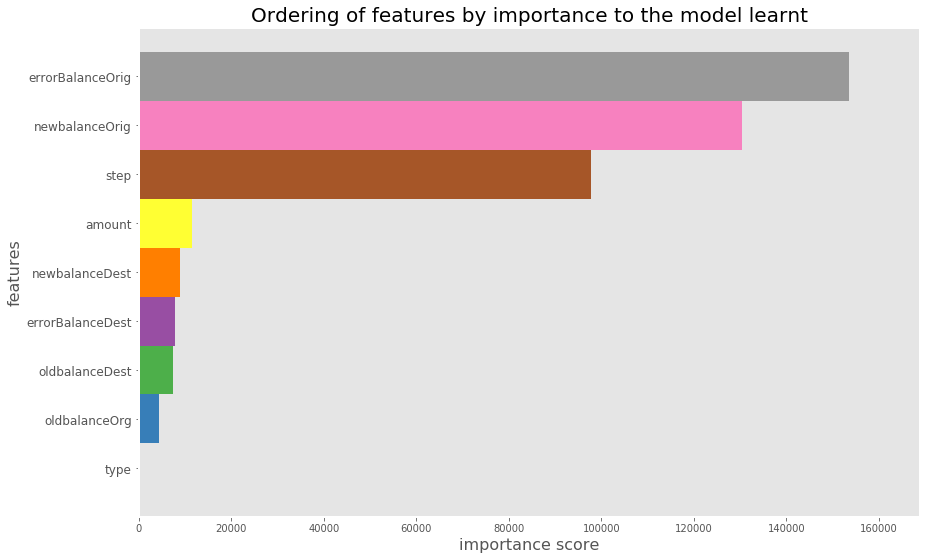

In [37]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

#### Visualizing the model

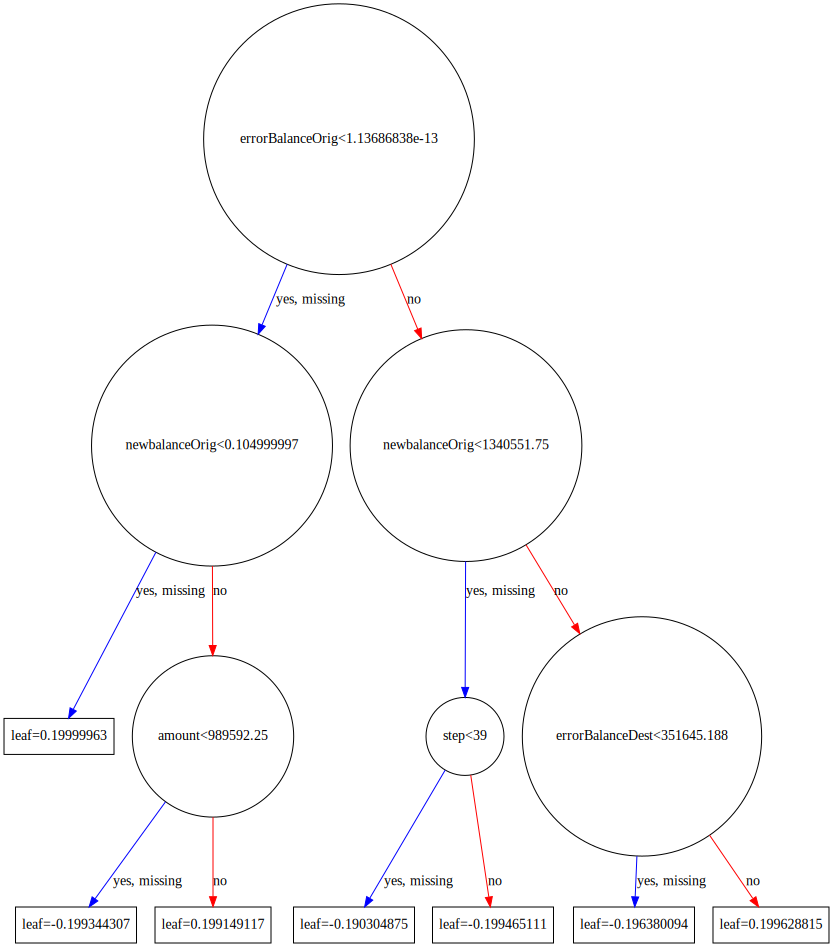

In [38]:
to_graphviz(clf)

#### Bias-Variance tradeoff

In [36]:
# Long computation in this cell. Much longer than model training
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX, trainY, scoring = 'average_precision')

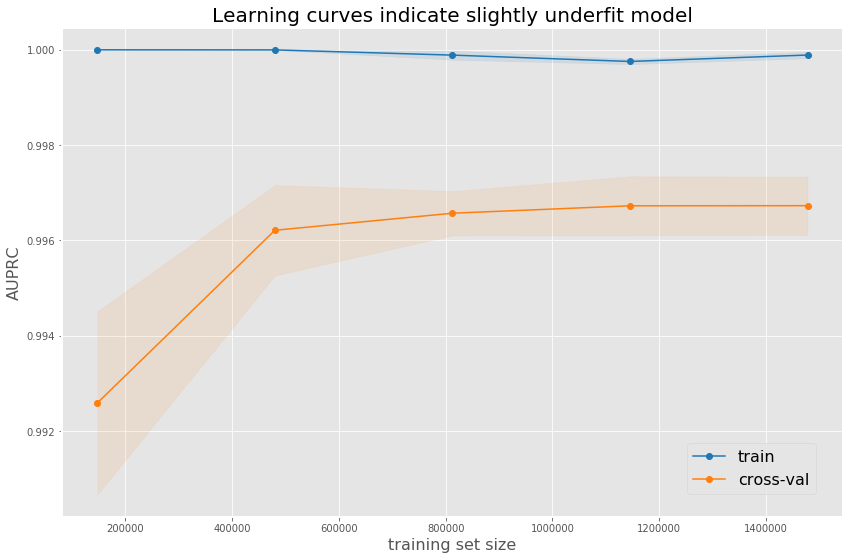

In [39]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

### Confusion Matrix

Recall metric in the testing dataset: 0.9976
Confusion matrix, without normalization
[[552261    151]
 [     4   1666]]


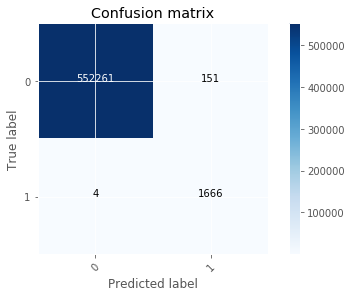

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(testY, predictY)

print("Recall metric in the testing dataset: {0:.4f}".format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In the Confusion Matrix above, the forward diagonal represents the correcly classified cases while the reverse diagonal shows the incorrectly classified classes.

The most important metric in the Confusion Matrix above is that only 4 True frauds are wrongly predicted as notFrauds. The model managed to correctly find 1666 True Frauds while causing inconvenience to only 151 good customers. From the metrics above, we see that the model is very promising to be productionized.

### Receiver Operating Characteristic (ROC)

ROC_AUC = 0.9995928893391685


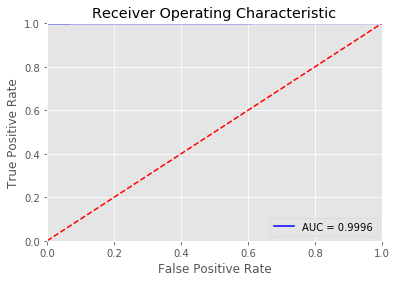

In [41]:
fpr, tpr, threshold = roc_curve(testY, probabilities[:,1])
roc_auc = auc(fpr, tpr)

print('ROC_AUC = {}'.format(roc_auc))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Precision Recall Curve

In [42]:
average_precision = average_precision_score(testY, probabilities[:,1])
print('Average precision-recall score: {0:0.4f}'.format(average_precision))

Average precision-recall score: 0.9986


Text(0.5,1,'2-class Precision-Recall curve: AP=0.9986')

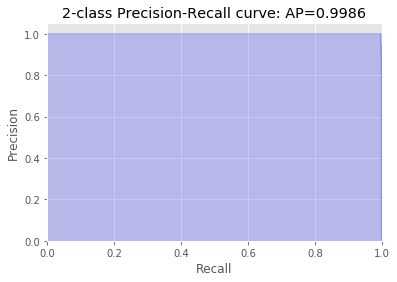

In [43]:
precision, recall, _ = precision_recall_curve(testY, probabilities[:,1])
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

## Streaming Flask Service

### Please start the Flask server before running the below cells ---> python serverXGB.py

#### Test the Streaming Flask Service 

I have moved the 'errorBalanceOrig' and 'errorBalanceDest' feature calculations to the Flask server itself to reduce the data flow over the network

In [44]:
r = requests.get("http://127.0.0.1:5000/predict?step=1&type=0&amount=0&oldbalanceOrg=0&newbalanceOrig=0.0&oldbalanceDest=0.0&newbalanceDest=0.0")
r.text

'Predicted Class: 1'

In [45]:
testXFlask = testX.drop(['errorBalanceOrig', 'errorBalanceDest'], axis = 1)
testXFlask.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
1114450,205,1,63243.44,0.0,0.00,1853683.32,1916926.76
669601,153,1,186686.03,386098.0,199411.97,2135106.65,2321792.68
481521,130,1,118390.25,1063.0,0.00,12650143.69,12768533.94
2666127,525,1,31267.07,0.0,0.00,3876206.35,3907473.42
357400,40,1,294134.47,452576.0,158441.53,223400.86,517535.32


#### Get Predictions from the streaming Flask application which takes transactions one by one and classifies them

In [46]:
for i in range(400,410):
    req = "http://127.0.0.1:5000/predict?step={}&type={}&amount={}&oldbalanceOrg={}&newbalanceOrig={}&oldbalanceDest={}&newbalanceDest={}".\
    format(int(testXFlask.iloc[i][0]),int(testXFlask.iloc[i][1]),testXFlask.iloc[i][2],testXFlask.iloc[i][3],testXFlask.iloc[i][4],testXFlask.iloc[i][5],testXFlask.iloc[i][6])
    r = requests.get(req)
    print(r.text)
    time.sleep(1)

Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 1
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0


Comparing the output from the streaming Flask application to the predictions from the model below

In [47]:
predictY[400:410]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

#### Simulate interarrival times following an exponential distribution with the streaming Flask application

In [49]:
expDistribution = np.random.exponential(1, 10)
for i in range(10):
    req = "http://127.0.0.1:5000/predict?step={}&type={}&amount={}&oldbalanceOrg={}&newbalanceOrig={}&oldbalanceDest={}&newbalanceDest={}".\
    format(int(testXFlask.iloc[i][0]),int(testXFlask.iloc[i][1]),testXFlask.iloc[i][2],testXFlask.iloc[i][3],testXFlask.iloc[i][4],testXFlask.iloc[i][5],testXFlask.iloc[i][6])
    r = requests.get(req)
    print(r.text)
    time.sleep(abs(1-expDistribution[i]))

Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0
Predicted Class: 0


Thanks to Arjun Joshua for the superb feature explanation